# PyEO Machine Learning: How to train your classifier..

- Here we will create a model to classify land cover (and thus enable the detection changes in forest cover between two date periods).
- To build a model, we will need training data. For PyEO, we define training data as pixel surface reflectance values over multiple wavebands and their corresponding 'true' land cover classes to which they should ideally be assigned by the model
- The next section below details how to generate this training data by manually delineating polygons using the QGIS software package

# Delineate Sample Areas using QGIS

## Instructional Video: Training sample delineation over South West Mau Forest

- Prof. Heiko Balzter will show a live demo of how to delineate training data in QGIS.
- Additionally, a recording of a previous demo is included with the files we distributed to attendees earlier, to view at your leisure.

## QGIS Training Data Specification Process Guide
- In the left hand panel of JupyterLab, navigate to `pyeo_1/models` within your installation directory and right click to download the sample image to your laptop
  - You need the file `composite_T36MYE_20230220T074941_clipped.tif`
- Once downloaded, open the image in QGIS on your laptop
- Add a shapefile layer
- Toggle editing of the shapefile layer
- Add a field which should be integer and named `class`
- Delineate features using the **Add Polygon Feature** tool. It looks like this: ![image](./Create_polygon.PNG) 
- Add training polygons for classes of interest to your shape file. 
- So that we can compare results please train for the following land use classes, using the integer CODE assigned to each in the table below:
  - `Primary Forest` 1; 
  - `Plantation Forest` 2;
  - `Bare Soil` 3;
  - `Crops` 4;
  - `Grassland` 5;
  - `Artificial` 13;
- Save your shapefile to your laptop hard drive
- Use the 'Upload' button to bring your saved shapefile to the folder 'model_dir' within your PyEO installation on SEPAL


## QGIS Tips

- Whilst in QGIS, make sure you have the **Digitizing** and **Advanced Digitizing** toolbars enabled. To do so, click:  
    - View > Toolbars > Tick Digitizing and Advanced Digitizing
- Avoid delineating near the edges of land cover, e.g. at the forest edge adjacent to a road. These edge pixels will capture the variation in land-cover at the sub-pixel level, confusing your classifier. 
- The **Reshape Features** tool, is extremely useful for extending already delineated polygons. Click inside the polygon you want to extend, then click any points outside of the polygon (covering your land cover class of interest), once ready - click inside the polygon to complete the loop, and right click to finish delineation. The tool icon looks like this: ![image](./Reshape_features.PNG)
- Install Google Earth Pro on your PC, https://www.google.com/earth/about/versions/ , which offers very-high resolution satellite imagery, and Google StreetView, to help you understand the land covers you are delineating.
- Install the QGIS plugin, **Send2GE**. This plugin sends your location directly to your installed Google Earth Pro. To do so, click on the Send2GE icon, ![image](./Send2GE.PNG), and then click on the location you want to view in Google Earth Pro.
- When developing models in future you may wish to develop your own choice of Land Cover classes and tailor them to what you want your model to achieve. Listed below is the full list of classes that we have evaluated for our `PyEO` forest alert classifier, but alternative classes may be more appropriate for your needs.

    1. Primary Forest
    2. Plantation Forest
    3. Bare Soil
    4. Crops
    5. Grassland
    6. Open Water
    7. Burn Scar
    8. Cloud
    9. Cloud Shadow
    10. Haze
    11. Sparse Woodland
    12. Dense Woodland
    13. Artificial
    

# Setup: Requirements to use this Notebook

## Select the virtual environment
- Use the drop-down list at the top right of the Jupyter notebook window
- Select `(venv) Python for Earth Observation (PyEO)`

## Check the working directory is set to `pyeo_1` within your PyEO installation

In [1]:
pwd

'/home/sepal-user/20230626_pyeo_installation/pyeo_1/notebooks'

In [2]:
cd /home/sepal-user/20230626_pyeo_installation/pyeo_1

/home/sepal-user/20230626_pyeo_installation/pyeo_1


In [3]:
pwd

'/home/sepal-user/20230626_pyeo_installation/pyeo_1'

# Import the Required Libraries

Before proceeding, let's check that the import statements from pyeo execute correctly.

In [4]:
import os
from pathlib import Path
from pyeo_1 import classification as cls
from pyeo_1 import filesystem_utilities as file_utils
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import ensemble as ens
import numpy as np
import joblib

print("Library imports complete")

Library imports complete


# Specify the Model Storage Directory

In [5]:
pyeo_dir = "/home/sepal-user/20230626_pyeo_installation/pyeo_1"

In [7]:
os.chdir(pyeo_dir)

In [8]:
pwd

'/home/sepal-user/20230626_pyeo_installation/pyeo_1'

In [9]:
model_dir = "./models/my_model"
log_dir = "./log"

# Create the folder if it doesn't yet exist
os.chdir(pyeo_dir)
if not os.path.exists(model_dir): 
    os.mkdir(model_dir)
if not os.path.exists(log_dir): 
    os.mkdir(log_dir)
    

- Use the File Browser to check your new folder now exists

# Initialise Logging

- When running `PyEO`, we record our processing efforts, parameters etc. in a log file (a `.log` file).
- If we are ever curious about what `PyEO` has done and when, we can look at the log file.  
- Below, we initialise our log file 
- **Note: the .log does not need to exist before running the function**

In [10]:
log_filename = "model_log.log"
log = file_utils.init_log(os.path.join(log_dir, log_filename))

# Let's add some information to the log
log.info(f'PyEO_1_Model_Training Notebook Started:')
log.info(f'- pyeo_dir set to: {pyeo_dir}')
log.info(f'- model_dir set to: {model_dir}')
log.info(f'- log_dir set to: {log_dir}')

2023-06-25 09:51:51,266: INFO: ****PROCESSING START****
2023-06-25 09:51:51,266: INFO: PyEO_1_Model_Training Notebook Started:
2023-06-25 09:51:51,267: INFO: - pyeo_dir set to: /home/sepal-user/20230626_pyeo_installation/pyeo_1
2023-06-25 09:51:51,268: INFO: - model_dir set to: ./models/my_model
2023-06-25 09:51:51,269: INFO: - log_dir set to: ./log


- Whenever a function writes to the log, the output will be displayed in the Python cell output, but the log file can also be viewed in a text editor.  
- **Right-Click on model_log.txt in the JupyterLab explorer to the left and select 'open' to view in a tab within JupyterLab.**   

# Model Training and Classification, Step by Step

- In this section, we will follow the individual steps to extract spectral information from the Sentinel-2 imagery using our training shapefiles, train a Random Forest model on the spectral values of the land cover classes, and classify a Sentinel-2 image tile.

## Extract Spectral Information from Sentinel-2 Imagery

- Since we have delineated our training polygons, we can now extract the spectral information from the imagery, by running `cls.extract_features_to_csv()` in the cell below.  
- First, specify the paths to the training shapefile, training raster and the out directory.

In [11]:
# specify the path of the training shapefile
training_shape_filename = "composite_T36MYE_20230220T074941_clipped_features.shp"
# specify the path of the training raster
training_raster_filename = "composite_T36MYE_20230220T074941_clipped.tif"
# specify the output folder
out_dir = model_dir
# specify the output filename for the model
model_name = "my_model"
model_out_filename = f"{model_name}.pkl"
# specify the output filename for the csv
feature_out_filename = f'{model_name}_features.csv'

log.info(f'File and Folder Specification Started::')
log.info(f'- training_shape_filename set to: {training_shape_filename}')
log.info(f'- training_raster_filename set to: {training_raster_filename}')
log.info(f'- out_dir set to: {out_dir}')
log.info(f'- model_out_filename set to: {model_out_filename}')
log.info(f'- feature_out_filename set to: {feature_out_filename}')


2023-06-25 09:54:19,370: INFO: File and Folder Specification Started::
2023-06-25 09:54:19,393: INFO: - training_shape_filename set to: composite_T36MYE_20230220T074941_clipped_features.shp
2023-06-25 09:54:19,394: INFO: - training_raster_filename set to: composite_T36MYE_20230220T074941_clipped.tif
2023-06-25 09:54:19,396: INFO: - out_dir set to: ./models/my_model
2023-06-25 09:54:19,397: INFO: - model_out_filename set to: my_model.pkl
2023-06-25 09:54:19,398: INFO: - feature_out_filename set to: my_model_features.csv


### Create `out_folder` if it does not exist

In [15]:
# if not os.path.exists(os.path.join(pyeo_dir, out_dir)):
    # os.mkdir(os.path.join(pyeo_dir, out_dir))

### Run `extract_features_to_csv`

Now, we can run the `cls.extract_features_to_csv` function.  
If the column heading of your training shapefile is not `CODE`, substitute the correct column name with the `attribute` argument.

In [12]:
# declare our path variables as easier to read variables
out_path = os.path.join(out_dir, feature_out_filename)
training_raster_path = os.path.join(model_dir, training_raster_filename)
training_shapefile_path = os.path.join(model_dir, training_shape_filename)

log.info(f'Feature Extraction Started:')
log.info(f'- out_path set to: {out_path}')
log.info(f'- training_raster_path set to: {training_raster_path}')
log.info(f'- training_shapefile_path set to: {training_shapefile_path}')

2023-06-25 09:54:22,904: INFO: Feature Extraction Started:
2023-06-25 09:54:22,961: INFO: - out_path set to: ./models/my_model/my_model_features.csv
2023-06-25 09:54:22,962: INFO: - training_raster_path set to: ./models/my_model/composite_T36MYE_20230220T074941_clipped.tif
2023-06-25 09:54:22,963: INFO: - training_shapefile_path set to: ./models/my_model/composite_T36MYE_20230220T074941_clipped_features.shp


In [13]:
# run the function to extract the spectral values and assigned classes from the training raster and training shapefile
cls.extract_features_to_csv(in_ras_path=training_raster_path,
                            training_shape_path=training_shapefile_path,
                            out_path=out_path,
                            attribute="class")

2023-06-25 09:54:25,372: INFO: Get training data from ./models/my_model/composite_T36MYE_20230220T074941_clipped.tif
2023-06-25 09:54:25,373: INFO:                    and ./models/my_model/composite_T36MYE_20230220T074941_clipped_features.shp
2023-06-25 09:54:26,291: INFO: Shape raster path /home/sepal-user/20230626_pyeo_installation/pyeo_1/tmpfe9f_cek/composite_T36MYE_20230220T074941_clipped_features_rasterised
2023-06-25 09:54:26,460: INFO: 4 bands in image file
2023-06-25 09:54:26,461: INFO: 11943 training pixels in shapefile


- Let's see what `features.csv` looks like, by reading in the csv and printing the first 5 rows.  
- Each row represents a pixel of a certain class. The first column in each row is the class of that pixel, with the columns after that being the Sentinel 2 blue, green, red and NIR value of that pixel.

In [43]:
# declare out_path from previous cell as csv_path, to avoid confusion
csv_path = out_path

# read in our spectral signatures
features = pd.read_csv(csv_path)

features.columns = ["class", "R", "G", "B", "NIR"]

# prints the first 5 rows of features
features.head(5)

,class,R,G,B,NIR
0,2.0,189.0,306.0,206.0,2906.0
1,2.0,190.0,295.0,204.0,2850.0
2,2.0,187.0,289.0,202.0,2773.0
3,2.0,170.0,297.0,202.0,2798.0
4,2.0,191.0,308.0,209.0,2873.0


In [15]:
features.tail(5)

,class,R,G,B,NIR
11937,5.0,365.0,618.0,487.0,3080.0
11938,5.0,353.0,614.0,478.0,2927.0
11939,5.0,341.0,595.0,472.0,2938.0
11940,5.0,348.0,615.0,473.0,3074.0
11941,5.0,359.0,583.0,471.0,3056.0


- Note: your model folder should now contain a .csv file of features - check using the file explorer on the left

## Model Creation and Training

- Now we can create a scikit-learn Extra Trees Classifier using PyEO:

In [16]:
log.info(f'Model Building Started:')

# initialise an Extra Trees Classifier
model = ens.ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.55, min_samples_leaf=2,
                                    min_samples_split=16, n_estimators=100, n_jobs=-1, class_weight='balanced')

# load signatures from csv file
features, labels = cls.load_signatures(csv_path, sig_datatype=np.int32)

# split into test and train samples, reserving 25% for testing model accuracy
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.25, random_state=101)

# train the model
model.fit(X_train, y_train)

# save the model
model_path = os.path.join(out_dir, model_out_filename)
joblib.dump(model, filename = model_path)

log.info(f"Model saved at {model_path}")

2023-06-25 09:54:42,935: INFO: Model Building Started:
2023-06-25 09:54:43,504: INFO: Model saved at ./models/my_model/my_model.pkl


- Note: your model folder should now contain a .pkl file containing your model - check using the file explorer on the left

## Accuracy Statistics

- Now that we have a model trained from shapefiles defined over Sentinel-2 image tile, we should assess the model accuracy.  
- To do that, we will use the model to predict the classes of `y_test` from the values of `X_test`, which comprise the 25% that we reserved for testing model accuracy.

In [17]:
log.info(f'Model Performance Analysis Started:')

confusion_matrix_out_filename = f'{model_name}_confusion_matrix.txt'
class_scores_out_filename = f'{model_name}_class_scores.txt'

# make a prediction
y_pred = model.predict(X_test)

# create a confusion matrix
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred,)

# write the confusion matrix to file
with open(os.path.join(out_dir, confusion_matrix_out_filename), "w") as txt:
    print(matrix, file=txt)

# write classification labels
target_names = ["Primary Forest",
          "Plantation Forest",
          "Bare Soil",
          "Crops",
          "Grassland",
          "Artificial"]

# view the matrix
print(matrix)

2023-06-25 09:54:47,574: INFO: Model Performance Analysis Started:


[[1482   34    0    0    0    0]
 [   8  337    0    0    0    0]
 [   0    0  152    0    0    0]
 [   0    0    0  343    1    0]
 [   0    0    0    0  458    0]
 [   0    0    0    0    1  170]]


In [18]:
# create classification metrics report
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, digits=6)

# write classification report to file
with open(os.path.join(out_dir, class_scores_out_filename), "w") as txt:
    print(report, file=txt)

# view the report
print(report)

                   precision    recall  f1-score   support

   Primary Forest   0.994631  0.977573  0.986028      1516
Plantation Forest   0.908356  0.976812  0.941341       345
        Bare Soil   1.000000  1.000000  1.000000       152
            Crops   1.000000  0.997093  0.998544       344
        Grassland   0.995652  1.000000  0.997821       458
       Artificial   1.000000  0.994152  0.997067       171

         accuracy                       0.985265      2986
        macro avg   0.983106  0.990938  0.986800      2986
     weighted avg   0.986019  0.985265  0.985459      2986



## Image Classification

- Once we are happy with the performance of the model we can now classify a Sentinel-2 image tiles so long as they have similar land use and vegetation cover (and thus spectral characteristics) to the imagery used to train the model.
- Here, we will simply use our training image and see how well the classification extends over the untrained areas of the image

In [22]:
log.info(f'Image Classification with Model Started:')

# test_raster_path = training_raster_path
test_raster_filename = 'composite_T36MYE_20230220T074941_clipped.tif'
test_raster_path = os.path.join(model_dir, test_raster_filename)

class_out_filename = f'{os.path.splitext(test_raster_filename)[0]}_full_class.tif'
class_out_path = os.path.join(out_dir, class_out_filename)

cls.classify_image(image_path=test_raster_path,
                   model_path=model_path,
                   class_out_path=class_out_path,
                   prob_out_path=None,
                   apply_mask=False,
                   out_format="GTiff",
                   chunks=10,
                   nodata=0,
                   skip_existing = False)

log.info(f'Classified Image Saved: {class_out_path}')


2023-06-25 10:18:26,784: INFO: Image Classification with Model Started:
2023-06-25 10:18:26,787: INFO: Classifying file: ./models/my_model/composite_T36MYE_20230220T074941_clipped.tif
2023-06-25 10:18:26,787: INFO: Saved model     : ./models/my_model/my_model.pkl
2023-06-25 10:18:27,173: INFO: Proportion of non-missing values: 100.00%
2023-06-25 10:18:27,455: INFO:    Number of chunks 10 Chunk size 265194 Chunk residual 6
2023-06-25 10:18:27,457: INFO:    Classifying chunk 1 of size 265194
2023-06-25 10:18:28,491: INFO:    Classifying chunk 2 of size 265194
2023-06-25 10:18:29,505: INFO:    Classifying chunk 3 of size 265194
2023-06-25 10:18:30,520: INFO:    Classifying chunk 4 of size 265194
2023-06-25 10:18:31,605: INFO:    Classifying chunk 5 of size 265194
2023-06-25 10:18:32,672: INFO:    Classifying chunk 6 of size 265194
2023-06-25 10:18:33,781: INFO:    Classifying chunk 7 of size 265194
2023-06-25 10:18:34,886: INFO:    Classifying chunk 8 of size 265194
2023-06-25 10:18:35,98

- Note: your model folder should now contain a classified image with '_full_class' appended to the raw image name - check using the file explorer on the left

## Visualise the Classified Imagery

Now we can now define a function to colormap and visualise the classified image

In [58]:
## Visualise the Classified Imagery

from matplotlib.colors import LinearSegmentedColormap
from osgeo import gdal
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

log.info(f'Classified Image Visualisation function has been defined.')

def visualise_classification(classified_path: str, labels: list):

    ds = gdal.Open(classified_path)
    array = np.array(ds.GetRasterBand(1).ReadAsArray())
   
    unique, _counts = np.unique(array, return_counts=True)

    counts=list(np.zeros(max(unique)+1,'int'))
    for i in range(0, len(_counts)):
        counts[unique[i]] = _counts[i]

    #counts, _ = np.histogram(array, bins = len(labels))
    print(counts)
   
    percent = counts / sum(counts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))


    def discrete_cmap(N, base_cmap=None):
        """Create an N-bin discrete colormap from the specified input map"""

        # this function was taken on 10/03/2023 from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
        # author: Jake Vanderplas
        
        # warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N))
        cmap_name = base.name + str(N)
        return base.from_list(cmap_name, color_list, N)

    cmap = discrete_cmap(len(labels), base_cmap="coolwarm")
    # cmap = discrete_cmap(len(labels), base_cmap="cubehelix")
    # cmap.set_bad("red")
    colour_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    if cmap.N <=14:
        log.info("Defining custom colour table for up to 13 classes and a missing data class of 0 (0..13)")
        colour_list = [
                      [0, 0, 0, 1],  # no data
                      [0, 100/255, 0, 1],  # Primary Forest
                      [154/255, 205/255, 50/255, 1],  # plantation Forest
                      [139/255, 69/255, 19/255, 1],  # Bare Soil
                      [189/255, 183/255, 107/255, 1],  # Crops
                      [240/255, 230/255, 140/255, 1],  # Grassland
                      [0, 0, 205/255, 1],  # Open Water
                      [128/255, 0, 0, 1],  # Burn Scar
                      [255/255, 255/255, 255/255, 1],  # cloud
                      [60/255, 60/255, 60/255, 1],  # cloud shadow
                      [128/255, 128/255, 128/255, 1],  # Haze
                      [46/255, 139/255, 87/255, 1],  # Open Woodland
                      [92/255, 145/255, 92/255, 1],  # Closed Woodland
                      [255/255, 30/255, 30/255, 1]  # Artificial
                      ]
    # Create the colormap
    n_bins = len(labels)
    cmap_name = 'my_colour_map'
    cmap = LinearSegmentedColormap.from_list(cmap_name, colour_list, N=n_bins)
   
    x = np.arange(0, len(labels))
    ax1.bar(x, percent, color=colour_list)
    ax1.set_title("Classes distribution")
    ax2.set_title("Classification raster displayed")
    ax2.imshow(array, cmap=cmap, aspect="auto", vmin=-0.5, vmax=len(labels)+0.5)
    plt.show()

    return


2023-06-25 12:20:50,742: INFO: Classified Image Visualisation function has been defined.


/tmp/ipykernel_453/651912266.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
2023-06-25 12:20:52,437: INFO: Defining custom colour table for up to 13 classes and a missing data class of 0 (0..13)


[0, 1427379, 107177, 38494, 314068, 647706, 0, 0, 0, 0, 0, 0, 0, 117122]


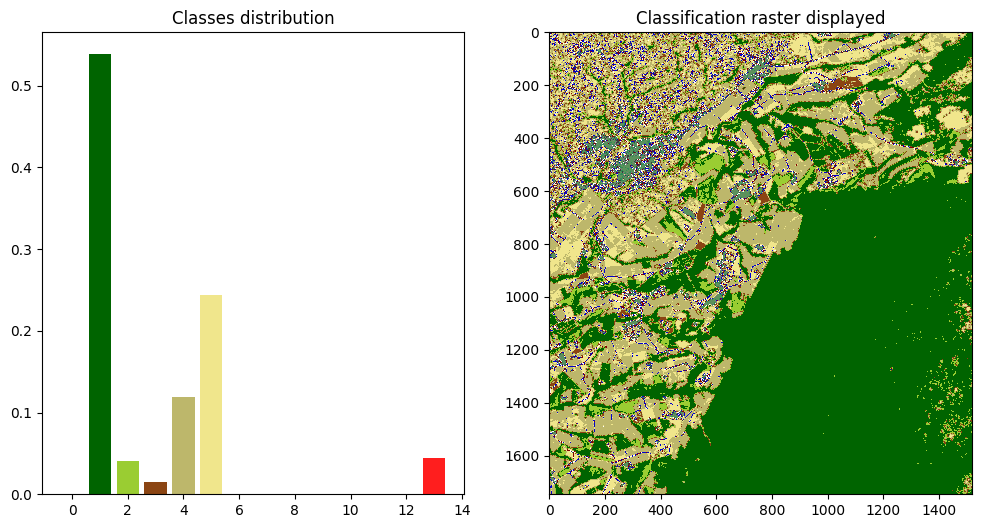

In [59]:
# create a list of class labels

labels = [
    "No Data",
    "Primary Forest",
    "Plantation Forest",
    "Bare Soil",
    "Crops",
    "Grassland",
    "Open Water",
    "Burn Scar",
    "Cloud",
    "Cloud Shadow",
    "Haze",
    "Open Woodland",
    "Closed Woodland",
    "Artificial"
    ]

visualise_classification(classified_path=class_out_path, labels=labels)

# Extended Model Training and Classification
- **NOTE: These PyEO capabilities are beyond the tutorial's scope but illustrative code and outputs are included below as a guide to their use**

## Model Building from Multiple Tiles and Shapefiles

- PyEO can also train a Random Forest classifier on multiple Sentinel-2 tiles with multiple training shapefiles. This approach can create a superior classifier because the training shapefiles can cover more tiles, providing the model with a variety of spectral values per class, and thus show greater versatility over a wide range of seasonal land cover and variation.


The `create_rf_model_for_region` function assumes the training rasters and training shapefiles are structured like the cell diagram below.   
**Note, the filenames do not need to be a specific format**

The second function will we use is `classify_directory`, which classifies multiple images in one call.

In [ ]:
# model_folder
    # training_raster_tile_1
    # training_shapefile_tile_1
    # training_raster_tile_2
    # training_shapefile_tile_2

In [ ]:
# pyeo_home = "/data/clcr/shared/IMPRESS/Ivan/kenya_national_prod"

In [ ]:
# out_folder = "models/model_36MYE_37MER_37NCC_20230417"

In [28]:
# # specify the path to the directory structure
# region_folder = os.path.join(pyeo_home, out_folder)

# # name the model that will be created
# model_file = "model_36MYE_37MER_37NCC_Unoptimised_20230417.pkl"
# model_path = os.path.join(region_folder, model_file)

# cls.create_rf_model_for_region(path_to_region=region_folder,
#                                model_out=model_path,
#                                attribute="class"
#                                #,attribute="CODE" # replace this line with the one above, if training shapefile has CODE as class heading
#                                )

2023-03-31 11:08:25,552: INFO: Create a random forest classification model for region based on tif/shp file pairs: ../models/model_training_1/
2023-03-31 11:08:25,557: INFO: Collecting training data from all tif/shp file pairs.
2023-03-31 11:08:25,558: INFO: Analysing shapefile: ../models/model_training_1/composite_T36NYF_20221202T075301_clipped.shp
2023-03-31 11:08:25,572: INFO: EPSG codes of the image and shapefile: 21097, 21097
2023-03-31 11:08:28,270: INFO: This training data shapefile includes 5 classes: [1, 3, 4, 5, 6]
2023-03-31 11:08:28,271: INFO: 4 bands in image file
2023-03-31 11:08:28,271: INFO: (4, 1588, 1464)
2023-03-31 11:08:28,272: INFO: (1588, 1464)
2023-03-31 11:08:28,273: INFO: 
[0 0 0 ... 0 0 0]
2023-03-31 11:08:28,273: INFO: 
[0 0 0 ... 0 0 0]
2023-03-31 11:08:28,274: INFO: 
[0 0 0 ... 0 0 0]
2023-03-31 11:08:28,303: INFO: (4, 8448)
2023-03-31 11:08:28,303: INFO: (8448,)
2023-03-31 11:08:28,304: INFO: 8448 training pixels in shapefile
2023-03-31 11:08:28,311: WARNI

In [33]:
# view classification report metrics
# with open(f"{os.path.join(pyeo_home, out_folder)}{os.sep}class_scores.txt", "r") as report:
#     print(report.read())
    

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       417
           3       0.98      1.00      0.99        56
           4       1.00      1.00      1.00        56
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00       431

    accuracy                           1.00       993
   macro avg       1.00      1.00      1.00       993
weighted avg       1.00      1.00      1.00       993




## Classify Directory

- Another useful PyEO capability to be aware of is that classification (and other functions) can be automatically over a directory of images
- This provides the basis to build automated data pipelines that process image sets as a chain from directory to directory
- The code below shows how to classify a directory of images given its path, a random forest model to apply, and a destination folder for the results

`cls.classify_directory` requires the `class_out_dir` to already exist, so make sure that this directory is present before running the function.

In [35]:
# provide the path of the directory of images to classify
# image_directory = pyeo_home

# # provide the path of the classified output folder
# class_out_dir = f"{os.path.join(pyeo_home, out_folder)}{os.sep}"

# # run the function to classify the directory of images you provided
# cls.classify_directory(in_dir=image_directory,
#                        model_path=model_path,
#                        class_out_dir=class_out_dir,
#                        chunks=10)

2023-03-31 11:37:20,430: INFO: Classifying files in ../models/model_training_1/
2023-03-31 11:37:20,431: INFO: Class files saved in ../models/model_training_1/output/
2023-03-31 11:37:20,432: INFO: Classifying file: ../models/model_training_1/composite_T36NYF_20221202T075301_clipped.tif
2023-03-31 11:37:20,433: INFO: Saved model     : ../models/model_training_1/output/model_from_region.pkl
2023-03-31 11:37:20,605: INFO: Proportion of non-missing values: 100.00%
2023-03-31 11:37:20,722: INFO:    Number of chunks 10 Chunk size 232483 Chunk residual 2
2023-03-31 11:37:20,722: INFO:    Classifying chunk 1 of size 232483
2023-03-31 11:37:22,297: INFO:    Classifying chunk 2 of size 232483
2023-03-31 11:37:23,845: INFO:    Classifying chunk 3 of size 232483
2023-03-31 11:37:25,318: INFO:    Classifying chunk 4 of size 232483
2023-03-31 11:37:26,794: INFO:    Classifying chunk 5 of size 232483
2023-03-31 11:37:28,346: INFO:    Classifying chunk 6 of size 232483
2023-03-31 11:37:29,901: INFO: 

## Visualise Classifications

Here, we can visualise the images we have just classified. Just pass the filename of the classified image.

[872429      0 167086      0 243031 819771 222515]


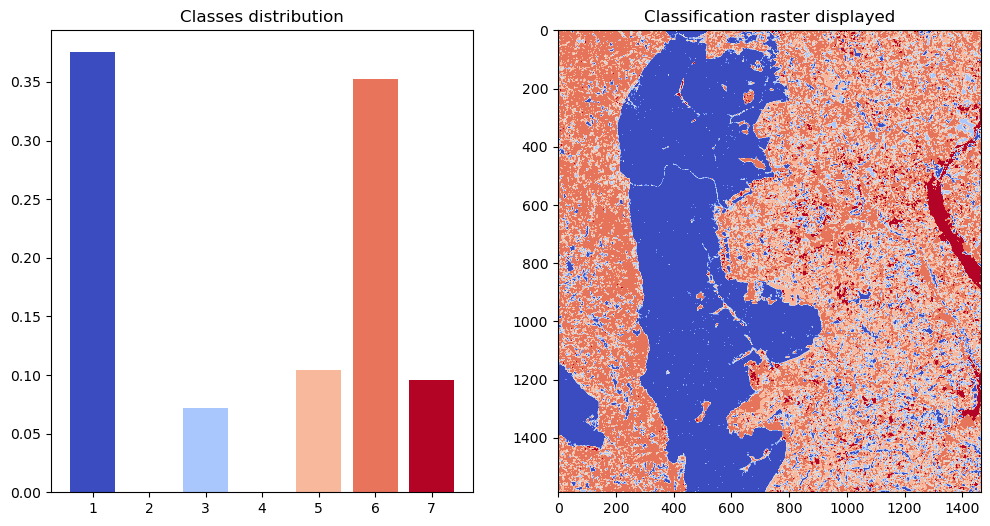

In [36]:
# specify the directory of a classified image
# classified_path = f"{class_out_dir}/composite_T36NYF_20221202T075301_clipped_class.tif"

# # create a list of class labels. In this example we have more classes because the additional classes were delineated to train this region rf model.
# labels = [
#     "Primary Forest",
#     "Plantation Forest",
#     "Bare Soil",
#     "Crops",
#     "Grassland",
#     "Open Water",
#     "Artificial"
# ]

# visualise_classification(classified_path=classified_path, labels=labels)

[1723112       0   79287       0  511502  171635  166410]


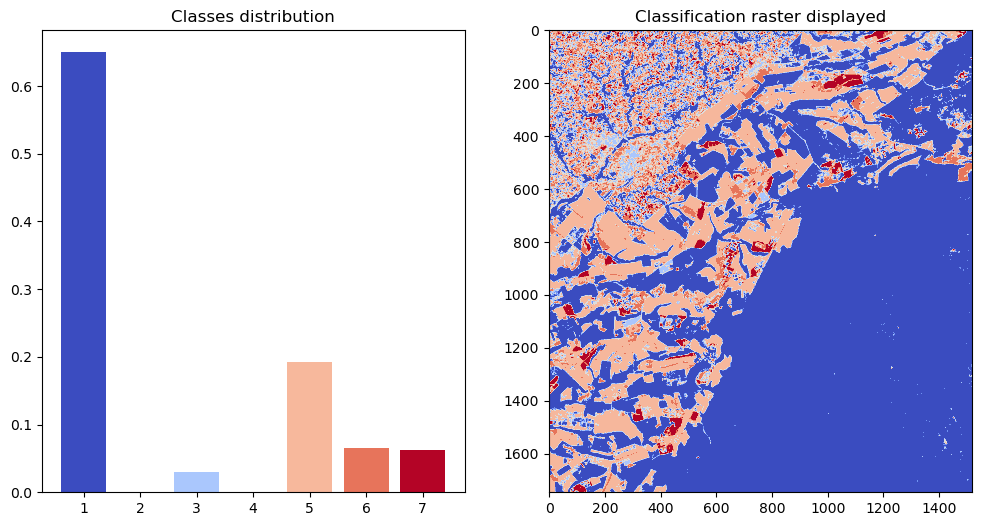

In [37]:
# # specify the directory of a classified image
# classified_path = f"{class_out_dir}/composite_T36MYE_20230220T074941_clipped_class.tif"

# visualise_classification(classified_path=classified_path, labels=labels)


**Question: Has this classifier done a better jo than than the simple one we created?**